In [3]:
import pandas as pd
import numpy as np
import joblib

df = pd.read_csv('../data/processed/marketing_final_encoded.csv')

In [4]:
# Load the trained Random Forest model
model = joblib.load('../models/best_random_forest_model.pkl')

In [ ]:
# Make a copy and remove 'Response' column if it exists
X = df.drop(columns=['Response'], errors='ignore')

In [6]:
y_prob = model.predict_proba(X)[:, 1]
y_pred = model.predict(X)

In [7]:
df['Predicted_Probability'] = y_prob
df['Predicted_Response'] = y_pred

In [8]:
responders = df[df['Predicted_Response'] == 1]
non_responders = df[df['Predicted_Response'] == 0]

In [9]:
high_confidence_responders = df[df['Predicted_Probability'] > 0.7]

In [10]:
responders.to_csv('../data/processed/responders_segment.csv', index=False)

In [11]:
responders.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Predicted_Probability,Predicted_Response
0,58138,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,0,0.555322,1
15,82800,0,0,23,1006,22,115,59,68,45,...,1,0,0,0,1,0,0,0,0.869532,1
17,37760,0,0,20,84,5,38,150,12,28,...,0,0,0,0,0,1,0,0,0.509135,1
18,76995,0,1,91,1012,80,498,0,16,176,...,0,0,0,1,0,0,0,0,0.526349,1
22,58607,0,1,63,867,0,86,0,0,19,...,1,0,0,1,0,0,0,0,0.524500,1


In [14]:
responders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 490 entries, 0 to 2239
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Income                    490 non-null    int64  
 1   Kidhome                   490 non-null    int64  
 2   Teenhome                  490 non-null    int64  
 3   Recency                   490 non-null    int64  
 4   MntWines                  490 non-null    int64  
 5   MntFruits                 490 non-null    int64  
 6   MntMeatProducts           490 non-null    int64  
 7   MntFishProducts           490 non-null    int64  
 8   MntSweetProducts          490 non-null    int64  
 9   MntGoldProds              490 non-null    int64  
 10  NumDealsPurchases         490 non-null    int64  
 11  NumWebPurchases           490 non-null    int64  
 12  NumCatalogPurchases       490 non-null    int64  
 13  NumStorePurchases         490 non-null    int64  
 14  NumWebVisitsMo

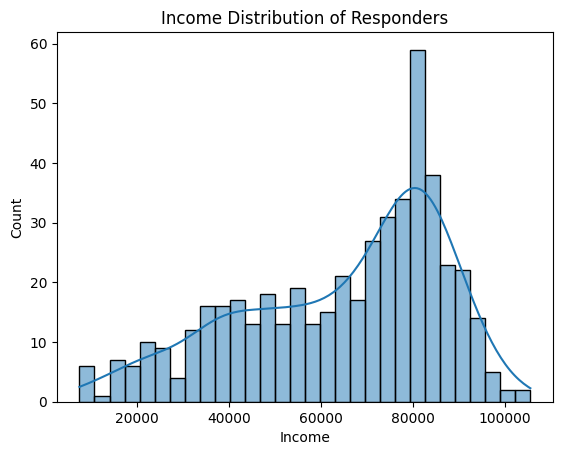

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of income
sns.histplot(responders['Income'], bins=30, kde=True)
plt.title("Income Distribution of Responders")
plt.show()


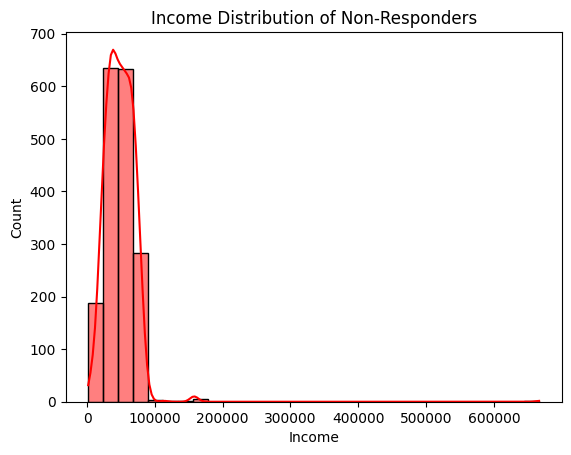

In [13]:
sns.histplot(non_responders['Income'], bins=30, kde=True, color='red')
plt.title("Income Distribution of Non-Responders")
plt.show()


We need to identify natural groupings within responders

In [15]:
features = [
    'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
    'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
    'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'Age', 'Customer_Tenure_Years', 'Total_Accepted_Campaigns',
    'Education_Basic', 'Education_Graduation', 'Education_Master',
    'Education_PhD', 'Marital_Status_Alone', 'Marital_Status_Divorced',
    'Marital_Status_Married', 'Marital_Status_Single',
    'Marital_Status_Together', 'Marital_Status_Widow',
    'Marital_Status_YOLO'
]


In [16]:
from sklearn.feature_selection import VarianceThreshold

# Initialize selector with desired threshold
selector = VarianceThreshold(threshold=0.01)

# Fit on selected features
selector.fit(responders[features])

# Get back the columns that passed the threshold
selected_features = responders[features].columns[selector.get_support()]

print("Selected features after VarianceThreshold:")
print(selected_features.tolist())


Selected features after VarianceThreshold:
['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Customer_Tenure_Years', 'Total_Accepted_Campaigns', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Together', 'Marital_Status_Widow']


In [17]:
# Scaling the faetures
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = responders[selected_features]
X_scaled = scaler.fit_transform(X)

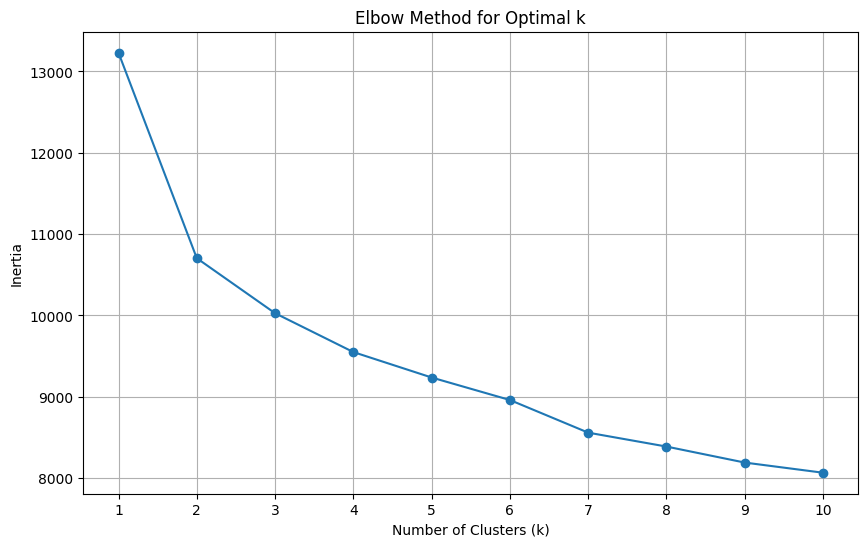

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(10,6))
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42)
responders['Cluster'] = kmeans.fit_predict(X_scaled)
print(responders['Cluster'].value_counts())

Cluster
3    166
1    111
2    111
0    102
Name: count, dtype: int64


C:\Users\elias\AppData\Local\Temp\ipykernel_14192\192257924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responders['Cluster'] = kmeans.fit_predict(X_scaled)


In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

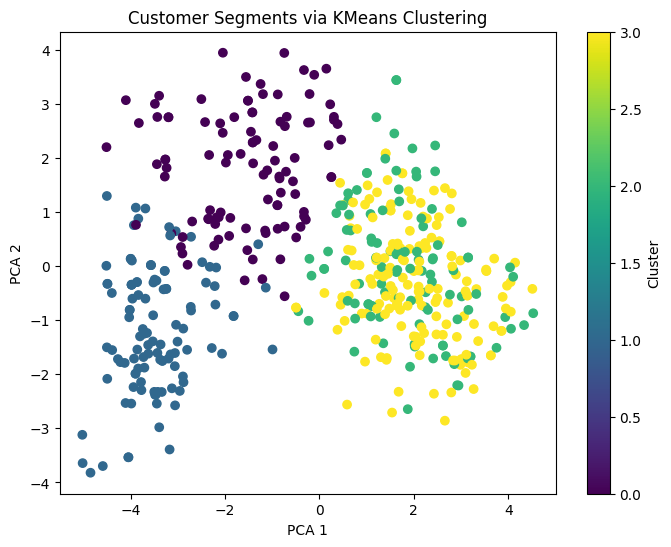

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=responders['Cluster'], cmap='viridis')
plt.title('Customer Segments via KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

In [23]:
responders['Cluster'] = kmeans.labels_

C:\Users\elias\AppData\Local\Temp\ipykernel_14192\688783988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responders['Cluster'] = kmeans.labels_


In [24]:
responders.groupby('Cluster')[selected_features].mean()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Total_Accepted_Campaigns,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
Cluster,,,,,,,,,,,,,,,,,,,,,
0,57752.039216,0.166667,0.892157,37.117647,661.411765,13.568627,129.196078,20.647059,13.794118,63.215686,...,1.078431,0.000000,0.372549,0.098039,0.480392,0.196078,0.284314,0.215686,0.196078,0.088235
1,32243.594595,0.864865,0.261261,31.369369,88.621622,9.171171,42.279279,12.486486,7.603604,36.198198,...,0.486486,0.063063,0.441441,0.189189,0.189189,0.090090,0.360360,0.288288,0.207207,0.045045
2,79078.072072,0.081081,0.090090,39.639640,740.909910,65.747748,489.549550,94.306306,63.819820,79.603604,...,1.387387,0.000000,0.513514,0.162162,0.216216,0.000000,1.000000,0.000000,0.000000,0.000000
3,80398.891566,0.012048,0.054217,44.542169,777.963855,70.855422,530.246988,98.578313,71.740964,76.716867,...,1.337349,0.000000,0.542169,0.180723,0.204819,0.150602,0.000000,0.439759,0.337349,0.066265


In [25]:
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']

In [26]:
# Save PCA components with index
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'], index=responders.index)
pca_df.to_csv('../data/processed/responders_pca.csv', index=True)

In [27]:
responders.to_csv('../data/processed/clustered_responders.csv', index=False)

In [28]:
import joblib
joblib.dump(kmeans, '../models/kmeans_model.pkl')

['../models/kmeans_model.pkl']